# BoomBikes - Linear Regression to understand the demand for bike rentals

**Problem Statement**

BoomBike offers a bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free.

BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 


BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.

**Objectives**
- To understand which variables are significant in predicting the demand for the shared bikes
- How well those variables describe the bike demands

**Approach**
- Data understanding 
- Loading the selecting the relevent data for analysis
- Check for duplicate data and missing values
- EDA - Univariate, Segmented and Bi-variate analysis with Visualization
- Data Preparation 
- Model development experiments
- Residual Analysis and Model validation on test data
- Conclusion

In [1]:
## Importing required pyhton libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
## Setting the display of pandas dataframe to show stated number of rows and columns
## setting default figure size for visualization

pd.options.display.max_rows=100
pd.options.display.max_columns=50
plt.rcParams['figure.figsize'] = (15,5)

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Data loading & Understanding 

In [4]:
## Loading the data from a CSV file and checking the first 5 rows

df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [5]:
df.shape

(730, 16)

In [6]:
## Checking for duplicate data based on unique identifiers

print(df.duplicated('instant').sum())
print(df.duplicated('dteday').sum())

0
0


**Understanding from data and data dictionary**

- data has 16 columns and 730 rows
    - Column `instant` is like index column, will be droped
- Column `cnt` is target column, which is continuous 
    - Column `cnt`, is derived from `casual` and `registered` as sum of these columns, so these columns will be droped 
- Column `dteday` is a date column and there are derived features from this column - `yr`, `mnth`, `weekday`, we will use the derived columns and will drop the timeseries column `dteday`, as we would like to consider this data as cross-sectional data
- We can also observe that there are no dulicate records

In [7]:
## Droping the irrelevent columns

df = df.drop(columns=['instant', 'dteday', 'casual', 'registered'], axis=1)
print(df.shape)
df.head(1)

(730, 12)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985


- We will use 12 columns in our further analysis

## Data Visualization and EDA

In [8]:
## Checking the data type for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


### Changing the data type
- Columns `season`,`yr`,`mnth`,`holiday`,`weekday`, `workingday`, `weathersit`, are categorical features (defination from data dictionary) 

In [9]:
## Converting to categorical columns 

cat_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
df[cat_cols] = df[cat_cols].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    category
 1   yr          730 non-null    category
 2   mnth        730 non-null    category
 3   holiday     730 non-null    category
 4   weekday     730 non-null    category
 5   workingday  730 non-null    category
 6   weathersit  730 non-null    category
 7   temp        730 non-null    float64 
 8   atemp       730 non-null    float64 
 9   hum         730 non-null    float64 
 10  windspeed   730 non-null    float64 
 11  cnt         730 non-null    int64   
dtypes: category(7), float64(4), int64(1)
memory usage: 35.1 KB


In [10]:
## Descriptive statistics of numerical columns

df.describe()

,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,4508.006849
std,7.506729,8.150308,14.237589,5.195841,1936.011647
min,2.424346,3.953480,0.000000,1.500244,22.000000
25%,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,26.880615,30.445775,72.989575,15.625589,5966.000000
max,35.328347,42.044800,97.250000,34.000021,8714.000000


**Observations**
- The range of independent numreical columns are similar, i.e, between 0 to 100
- The mean and median of the numerical columns are close by

### Checking Missing Values

In [11]:
## Checking missing values by feature

df.isna().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

- There are no missing values

## Analysing individual features & EDA
- Univariate analysis of individual feaures with visualization
- Segmented and Bivariate analysis of the dependent variable with target variable 
- Multivariate analysis understanding the correlation of numreical dependent variables with target varriable 

**Analysing target variable - `cnt`**

In [12]:
## Descriptive statistics of feature 'cnt'

df.cnt.describe()

count     730.000000
mean     4508.006849
std      1936.011647
min        22.000000
25%      3169.750000
50%      4548.500000
75%      5966.000000
max      8714.000000
Name: cnt, dtype: float64

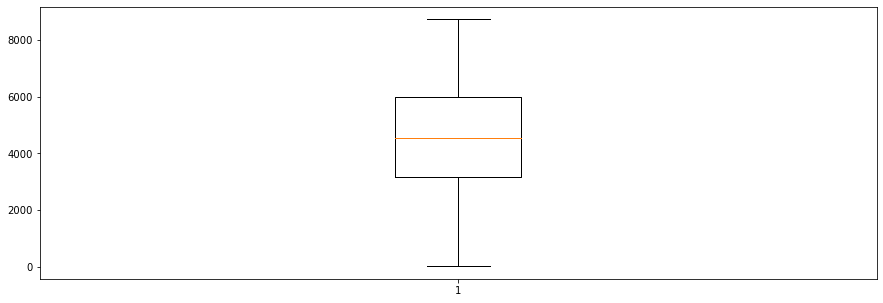

In [13]:
## Boxplot for feature 'cnt'

plt.boxplot(df.cnt);

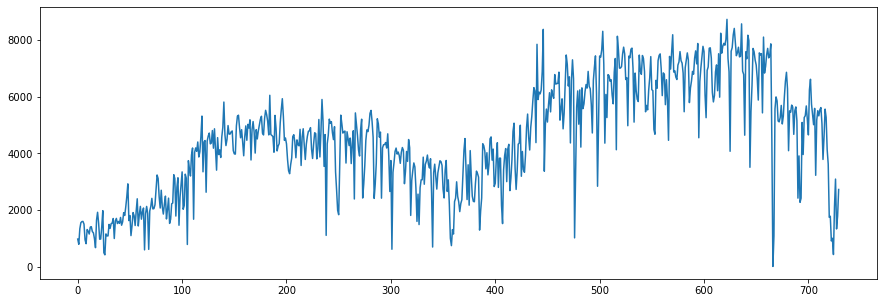

In [14]:
## plotting feature 'cnt'

plt.plot(df.cnt);

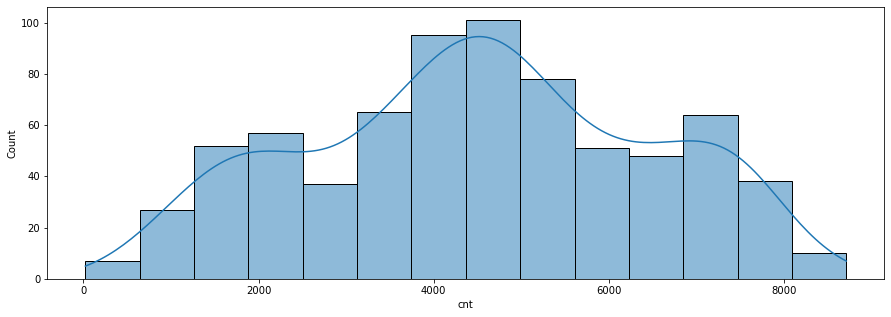

In [15]:
## Distribution plot for feature 'cnt'

sns.histplot(df.cnt, stat= 'count', kde=True, );

**Observations**

- Target Column `cnt` doesnot have outliers
- Mean = 4508 and median = 4548, and are close
- Most of the data spread arround mean or median almost symetrically 
- There is a seasonality and trend in the data, which we will ignore for this analysis

**Analysing feature `Season`**

In [16]:
# count of classes of feature season

df.season.value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

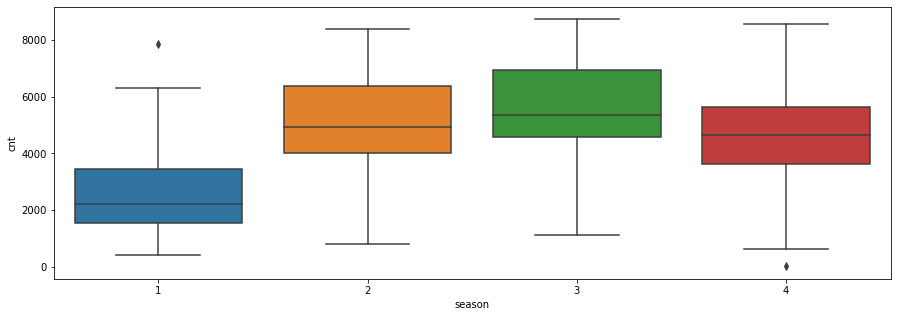

In [17]:
## ## Boxplot - Segmenting Total Rentals ('cnt') by factors of season column

sns.boxplot(x = df.season, y = df.cnt);

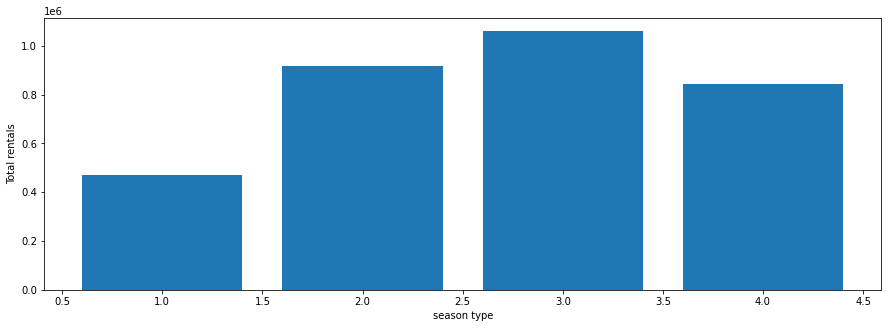

In [18]:
## Segmented analysis of season factors with total rentals 

grouped = df.cnt.groupby(by = df.season).sum()
plt.bar(x=grouped.index.values, height = grouped.values)
plt.xticks = grouped.index.values
plt.xlabel('season type')
plt.ylabel('Total rentals');

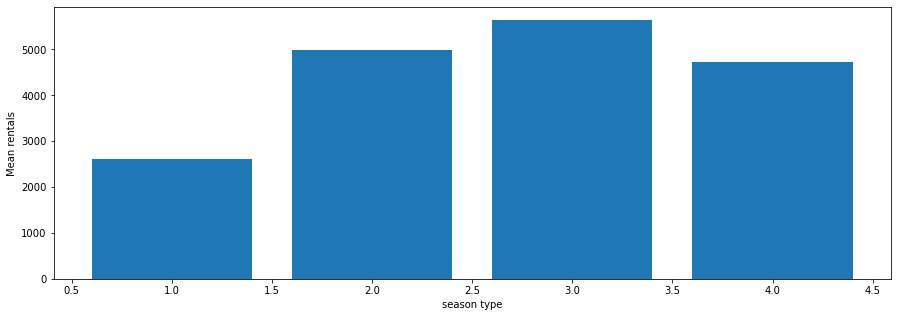

In [19]:
## Segmented analysis of season factors with mean of total rentals  

grouped = df.cnt.groupby(by = df.season).mean()
plt.bar(x=grouped.index.values, height = grouped.values)
plt.xticks = grouped.index.values
plt.xlabel('season type')
plt.ylabel('Mean rentals');

In [20]:
## Mean of Total rentals by season factors

df.groupby(by=df.season).mean()['cnt']

season
1    2608.411111
2    4992.331522
3    5644.303191
4    4728.162921
Name: cnt, dtype: float64

**Observations**
- There are 4 classes in feature `season`
- We obsreve that **season 3 (fall) has the heighest mean value for total rental** followed by season 2 (summer) and 4(winter)
- Same distribution can be observed with total rentals for season classes

**Analysing feature `yr`**

In [21]:
df.yr.value_counts()

0    365
1    365
Name: yr, dtype: int64

In [22]:
## Sum of Total Rentals by year

df['cnt'].groupby(by=df.yr).sum()

yr
0    1243103
1    2047742
Name: cnt, dtype: int64

In [23]:
## Mean of Total Rentals by year

df['cnt'].groupby(by=df.yr).mean()

yr
0    3405.761644
1    5610.252055
Name: cnt, dtype: float64

**Observations**
- We can observe that yr has two classes representing 2018 and 2019
- These two classes has equal data count
- There is an increase in total rentals from 2018 to 2019, representing growth in the business year on year
- However, We should drop this column, as this coulmn represent temporal data and not important for the current analysis as we are not doing time-series analysis

In [24]:
## droping `yr` feature

df = df.drop(columns='yr', axis=1)
df.shape

(730, 11)

**Analysing feature `mnth`**

In [25]:
## Unique values in 'mnth' column

df.mnth.unique()

[1, 2, 3, 4, 5, ..., 8, 9, 10, 11, 12]
Length: 12
Categories (12, int64): [1, 2, 3, 4, ..., 9, 10, 11, 12]

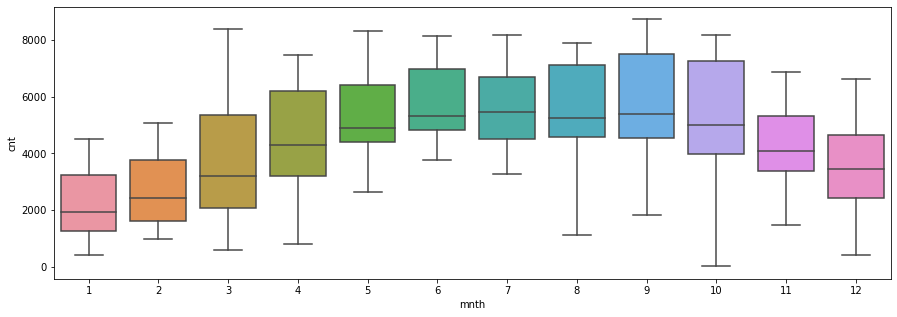

In [26]:
## Boxplot - Segmenting Total Rentals ('cnt') by month wise

sns.boxplot(x = df.mnth, y = df.cnt);

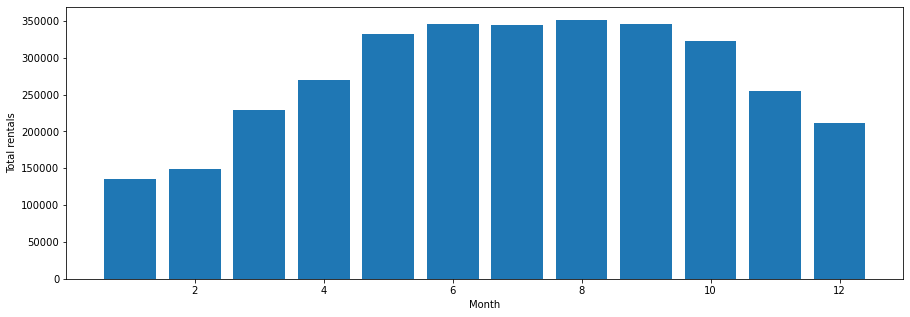

In [27]:
## Segmenting Sum of Total Rentals ('cnt') by month wise

grouped = df.cnt.groupby(by = df.mnth).sum()
plt.bar(x=grouped.index.values, height = grouped.values)
plt.xticks = grouped.index.values
plt.xlabel('Month')
plt.ylabel('Total rentals');

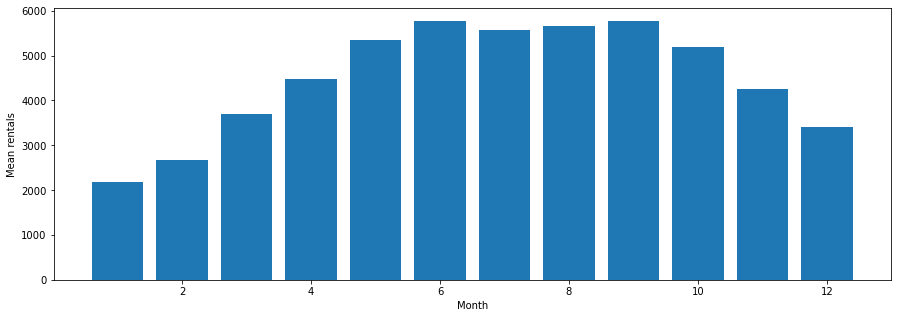

In [28]:
## Segmenting Mean of Total Rentals ('cnt') by month wise

grouped = df.cnt.groupby(by = df.mnth).mean()
plt.bar(x=grouped.index.values, height = grouped.values)
plt.xticks = grouped.index.values
plt.xlabel('Month')
plt.ylabel('Mean rentals');

**Observations**
- the distribution of total and mean rentals across months shows that, the rentals are high from month 5 to 10 (May till October)
- the rentals are lowest on month 1 followed by month 2
- We can see that 'seson' affect on the rentals by months, i.e, season - summer has the heigest total rentals

**Analysing feature `holiday`**

In [29]:
## Unique values in 'holiday' column
df.holiday.value_counts()

0    709
1     21
Name: holiday, dtype: int64

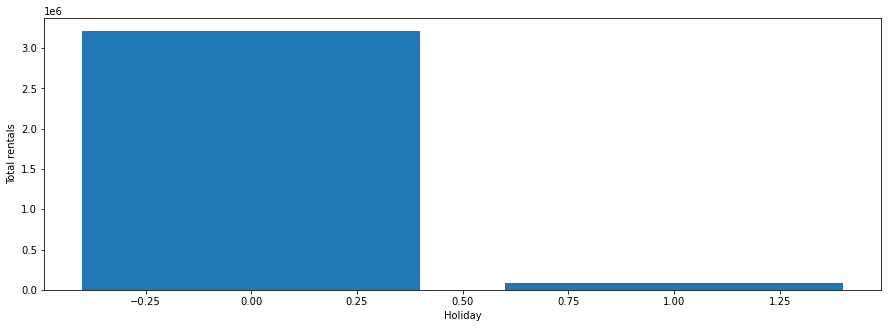

In [30]:
## Segmenting Sum of Total Rentals ('cnt') for factors holiday column

grouped = df.cnt.groupby(by = df.holiday).sum()
plt.bar(x=grouped.index.values, height = grouped.values)
plt.xticks = grouped.index.values
plt.xlabel('Holiday')
plt.ylabel('Total rentals');

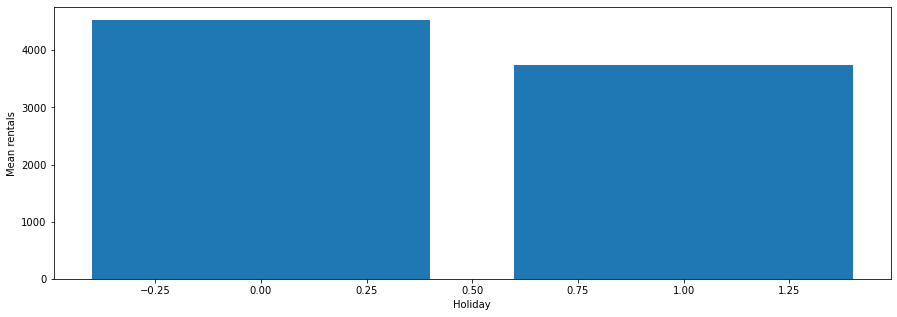

In [31]:
## Segmenting Mean of Total Rentals ('cnt') for factors of holiday column

grouped = df.cnt.groupby(by = df.holiday).mean()
plt.bar(x=grouped.index.values, height = grouped.values)
plt.xticks = grouped.index.values
plt.xlabel('Holiday')
plt.ylabel('Mean rentals');

In [32]:
## Segmenting Mean of Total Rentals ('cnt') for factors of holiday column
df.cnt.groupby(by = df.holiday).mean()

holiday
0    4530.90268
1    3735.00000
Name: cnt, dtype: float64

In [33]:
## Contribution of Total Rentals ('cnt') for factors of holiday column

df['cnt'].groupby(by=df.holiday).sum()*100/df.cnt.sum()

holiday
0    97.61657
1     2.38343
Name: cnt, dtype: float64

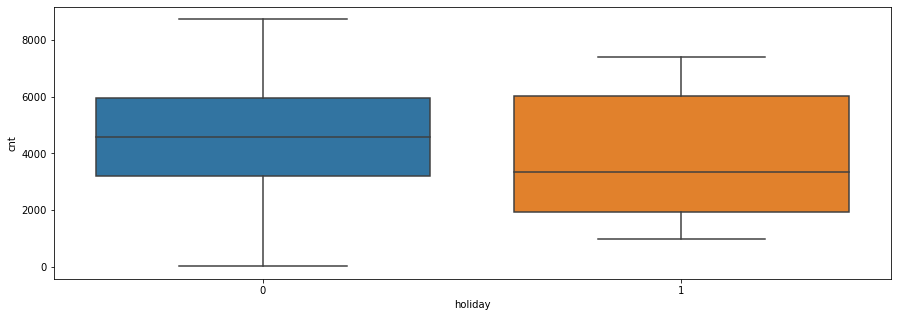

In [34]:
## Boxplot - Segmenting Total Rentals ('cnt') by factors of holiday column

sns.boxplot(x = df.holiday, y = df.cnt);

**Observations**
- There are only 21 holidays in the data, contributing to 2.4% of total rentals 
- There is some difference in mean of rentals between holidays and non-holidays

**Analysing feature `weekday`**

In [35]:
## Unique values in 'weekday' column
df.weekday.unique()

[6, 0, 1, 2, 3, 4, 5]
Categories (7, int64): [0, 1, 2, 3, 4, 5, 6]

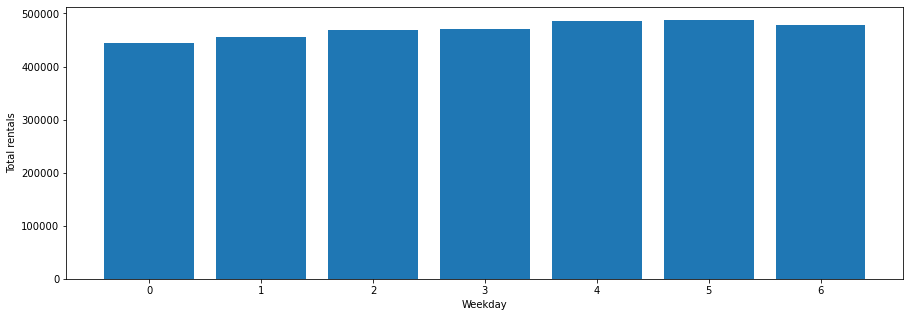

In [36]:
## Segmenting Sum of Total Rentals ('cnt') for factors of weekday column

grouped = df.cnt.groupby(by = df.weekday).sum()
plt.bar(x=grouped.index.values, height = grouped.values)
plt.xticks = grouped.index.values
plt.xlabel('Weekday')
plt.ylabel('Total rentals');

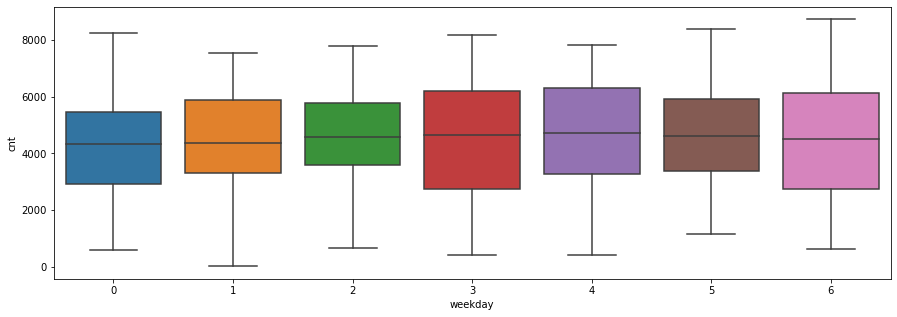

In [37]:
## Boxplot - Segmenting Total Rentals ('cnt') by factors of weekday column

sns.boxplot(x = df.weekday, y = df.cnt);

**Observations**
- The Total rentals and median of rentals for all weekdays are approximately similar, not much of variations.  

**Analysing feature `workingday`**

In [38]:
## Unique valies for column 'workingday'
df.workingday.value_counts()

1    499
0    231
Name: workingday, dtype: int64

In [39]:
## Contribution of Total Rentals ('cnt') for factors of `workingday` column
df['cnt'].groupby(by=df.workingday).sum()*100/df.cnt.sum()

workingday
0    30.395506
1    69.604494
Name: cnt, dtype: float64

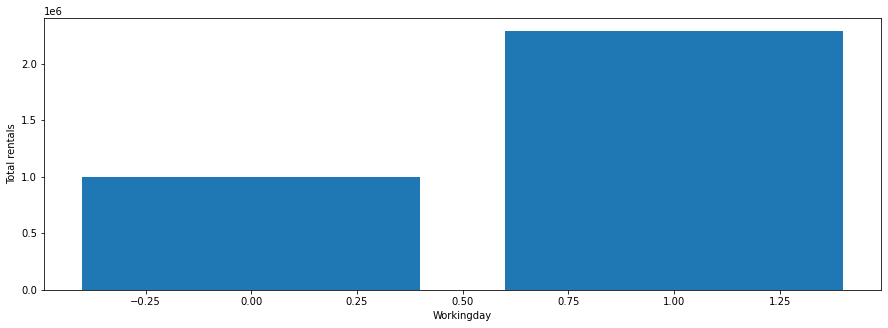

In [40]:
## Segmenting Sum of Total Rentals ('cnt') for factors of workingday column

grouped = df.cnt.groupby(by = df.workingday).sum()
plt.bar(x=grouped.index.values, height = grouped.values)
plt.xticks = grouped.index.values
plt.xlabel('Workingday')
plt.ylabel('Total rentals');

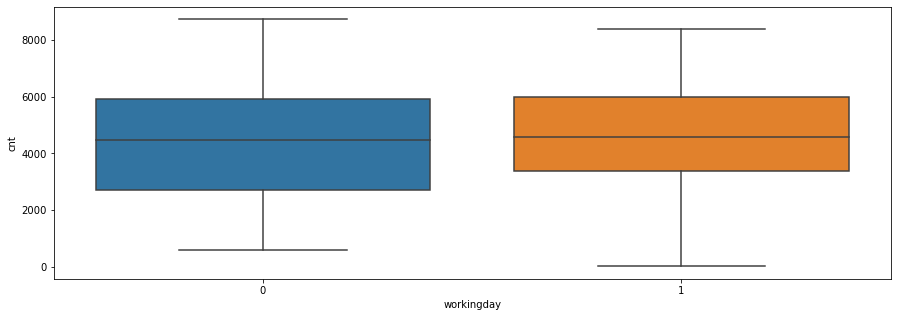

In [41]:
## Boxplot - Segmenting Total Rentals ('cnt') by factors of workingday column

sns.boxplot(x = df.workingday, y = df.cnt);

**Observations**
- There are 2 classes - 1 = Workingday, 0 = non-workingday 
- There are 499 holidays in the data, contributing to 70% of total rentals, while 231 non-working days contributes to 30% 
- However the no significant difference in the median rentals on non-working days and working days

**Analysing feature `weathersit`**

In [42]:
## Unique values for `weathersit` column
df.weathersit.value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

In [43]:
## Contribution of Total Rentals ('cnt') for factors of `weathersit` column

df['cnt'].groupby(by=df.weathersit).sum()*100/df.cnt.sum()

weathersit
1    68.613137
2    30.236125
3     1.150738
Name: cnt, dtype: float64

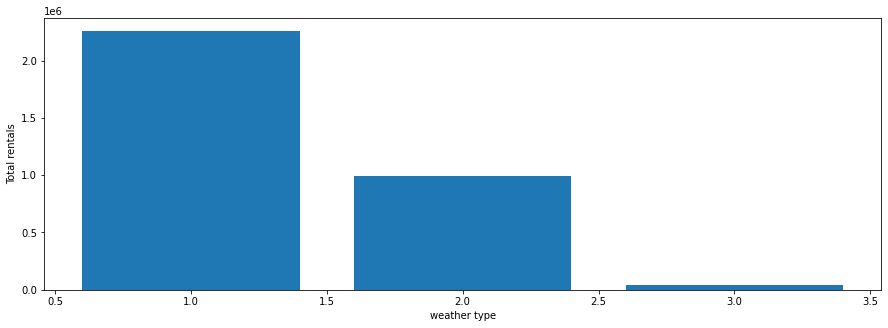

In [44]:
## Segmenting Sum of Total Rentals ('cnt') for factors of `weathersit` column

grouped = df.cnt.groupby(by = df.weathersit).sum()
plt.bar(x=grouped.index.values, height = grouped.values)
plt.xticks = grouped.index.values
plt.xlabel('weather type')
plt.ylabel('Total rentals');

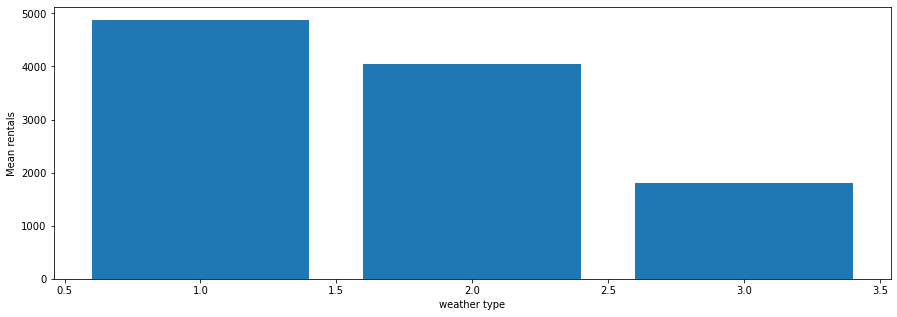

In [45]:
## Segmenting mean of Total Rentals ('cnt') for factors of `weathersit` column

grouped = df.cnt.groupby(by = df.weathersit).mean()
plt.bar(x=grouped.index.values, height = grouped.values)
plt.xticks = grouped.index.values
plt.xlabel('weather type')
plt.ylabel('Mean rentals');

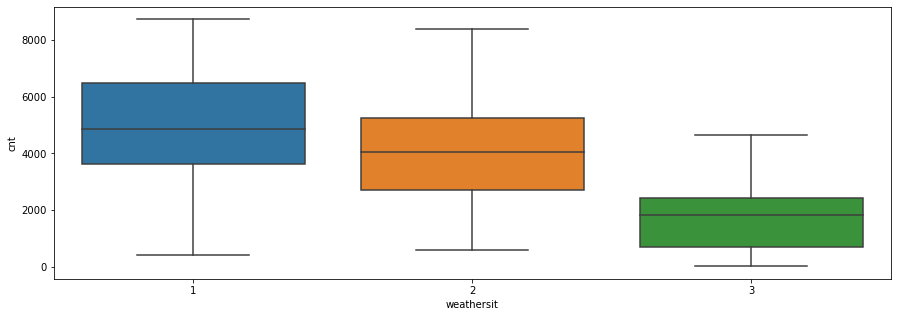

In [46]:
## Boxplot - Segmenting Total Rentals ('cnt') by factors of `weathersit` column

sns.boxplot(x = df.weathersit, y = df.cnt);

**Observations**
- There are 4 classes 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- It is observed that the weather type class 1 contribute close to 69% of rentals and class 2 contributes 30% of rentals, class 3 just below 2% and there is no rentals on weather type class 4
- The mean rental for calss 1 weather type is higher than any other class

**Analysing feature `temp`**

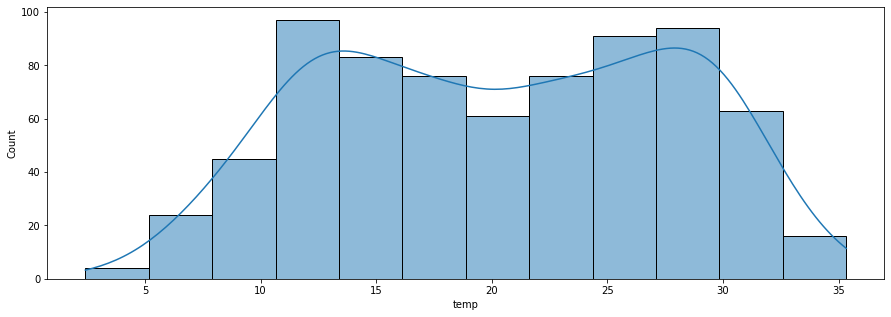

In [47]:
## Plotting the distribution of 'temp' column
sns.histplot(df.temp, kde=True);

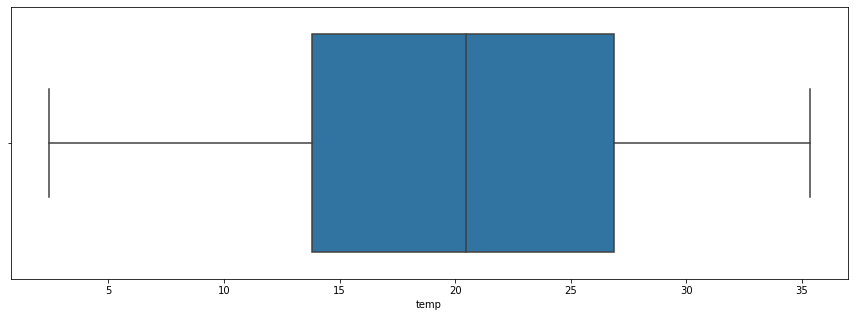

In [48]:
## Boxplot for 'temp'
sns.boxplot(df.temp);

Correlation between temp and cnt : 0.6270


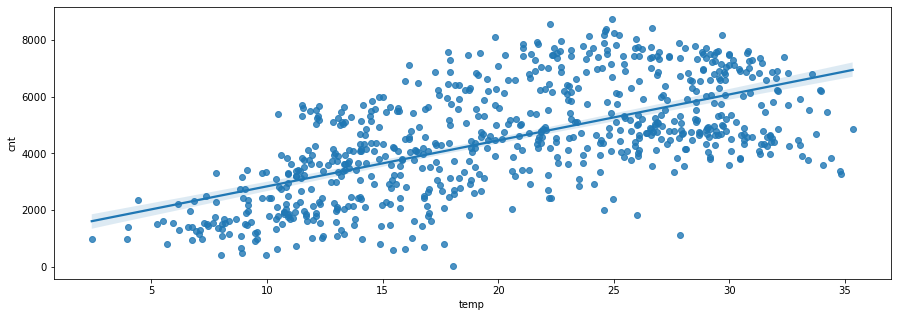

In [49]:
##Bivariate Analysis 'temp' vs 'cnt'

sns.regplot(df.temp, df.cnt, );
print('Correlation between temp and cnt : %.4f'%pearsonr(df.temp, df.cnt)[0])

**Observations**
- The 'temp' column is bi-modal
- The 'temp' column has no significant outliers
- The relationship between 'temp' and 'cnt' is linear and has a positive correlation of 0.627

**Analysing feature `atemp`**

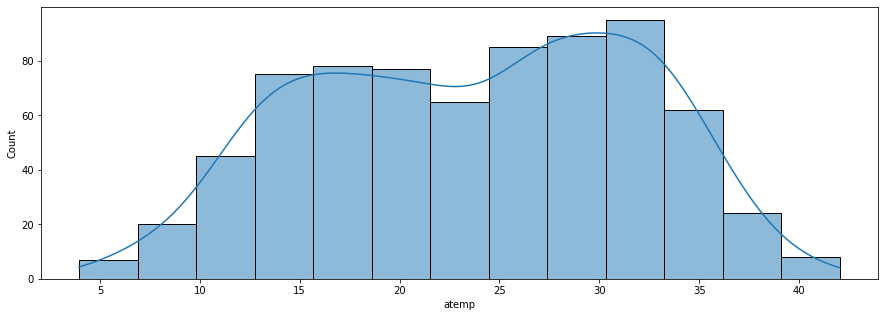

In [50]:
## Plotting the distribution of 'atemp' column
sns.histplot(df.atemp, kde=True);

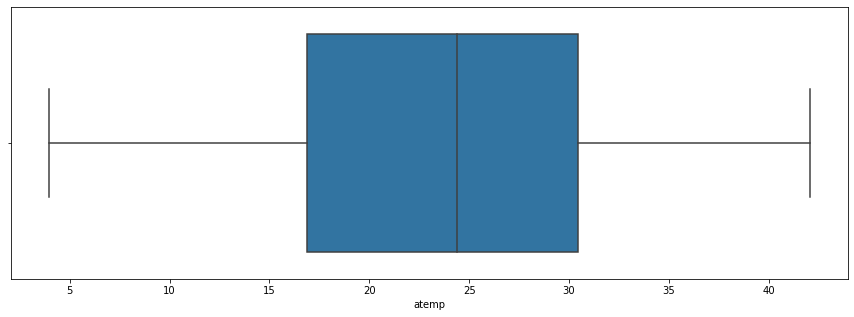

In [51]:
## Boxplot for 'atemp'
sns.boxplot(df.atemp);

Correlation between temp and cnt : 0.6307


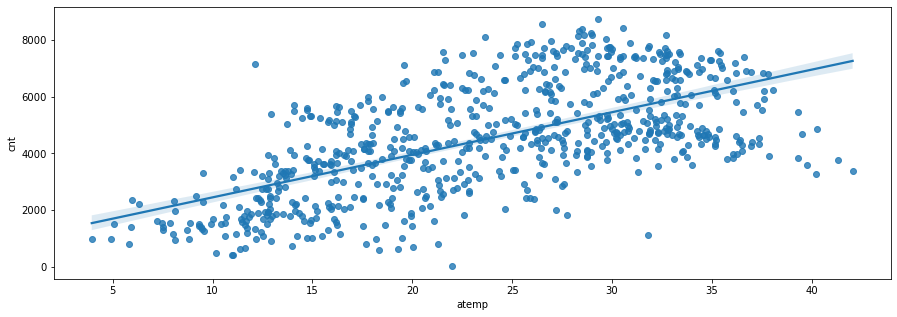

In [52]:
##Bivariate Analysis 'atemp' vs 'cnt'

sns.regplot(df.atemp, df.cnt, );
print('Correlation between temp and cnt : %.4f'%pearsonr(df.atemp, df.cnt)[0])

**Observations**
- The 'atemp' column is bi-modal similar to 'temp' column
- The 'atemp' column has no significant outliers
- The relationship between 'atemp' and 'cnt' is linear and has a positve correlation of 0.63

**Analysing feature `windspeed`**

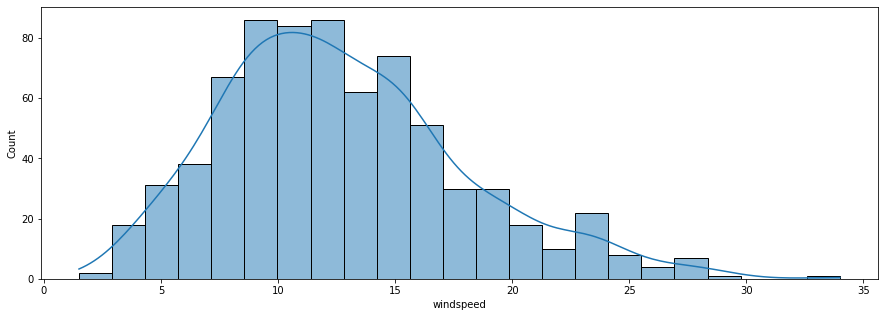

In [53]:
## Plotting the distribution of 'windspeed' column
sns.histplot(df.windspeed, kde=True);

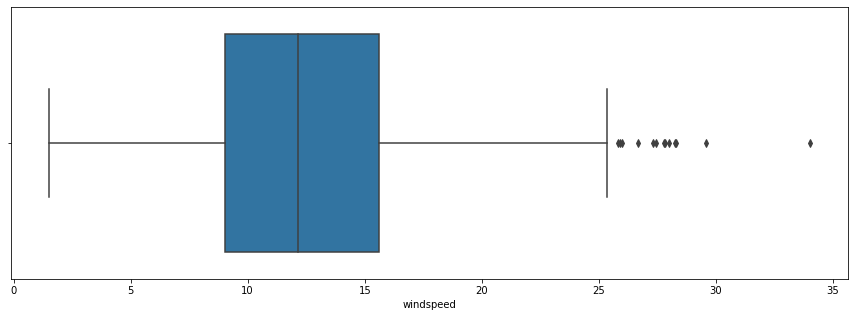

In [54]:
## Boxplot for 'windspeed'
sns.boxplot(df.windspeed);

Correlation between temp and cnt : -0.2351


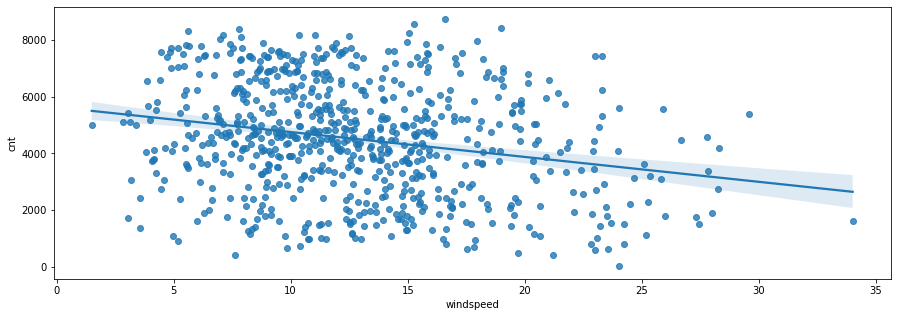

In [55]:
##Bivariate Analysis 'windspeed' vs 'cnt'

sns.regplot(df.windspeed, df.cnt, );
print('Correlation between temp and cnt : %.4f'%pearsonr(df.windspeed, df.cnt)[0])

**Observations**
- The 'windspeed' column is bit right skiwed, indicating presence of extreme values
- The 'windspeed' column has some outliers
- The relationship between 'windspeed' and 'cnt' is not clearly linear and has a mild negitive correlation of -0.235

**Analysing feature `hum` (humidity)**

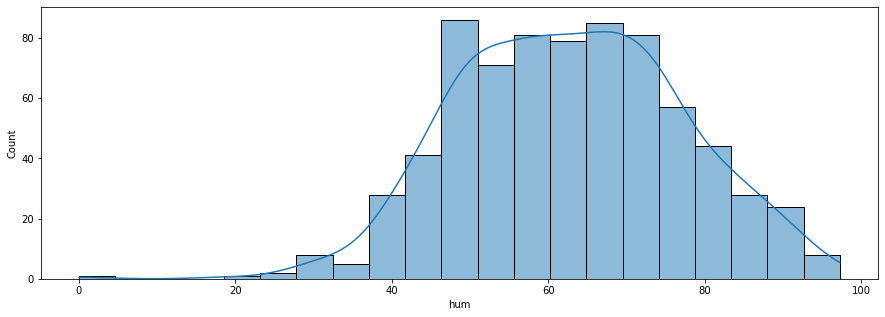

In [56]:
## Plotting the distribution of 'hum' column
sns.histplot(df.hum, kde=True);

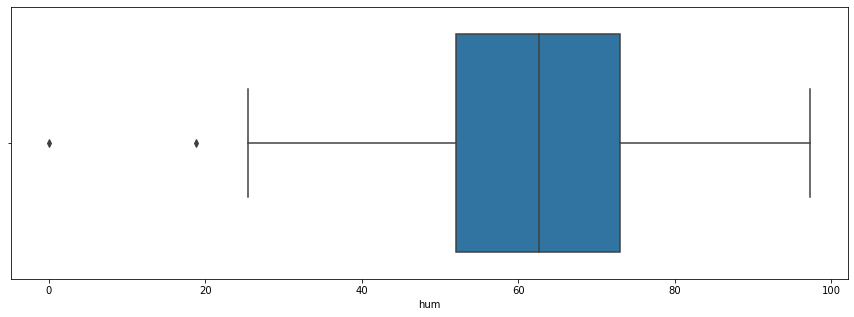

In [57]:
## Boxplot for 'hum'
sns.boxplot(df.hum);

Correlation between temp and cnt : -0.0985


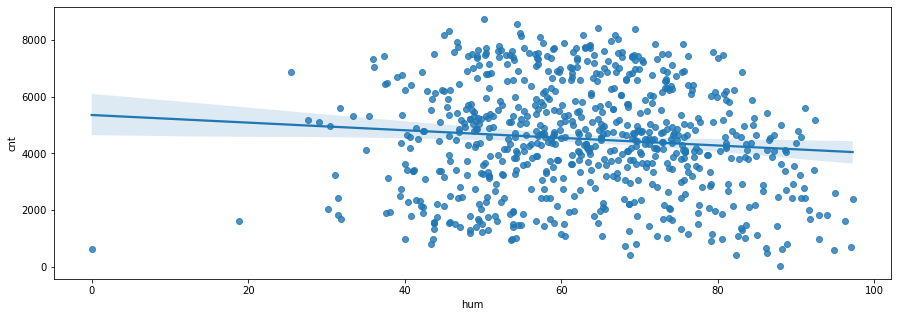

In [58]:
##Bivariate Analysis 'hum' vs 'cnt'

sns.regplot(df.hum, df.cnt, );
print('Correlation between temp and cnt : %.4f'%pearsonr(df.hum, df.cnt)[0])

**Observations**
- The 'hum' column is bit left skiwed, indicating presence of extreme values
- The 'hum' column has some outliers
- The relationship between 'hum' and 'cnt' is not linear and has a negligible negitive correlation of -0.0985

**Multivariate Analysis**

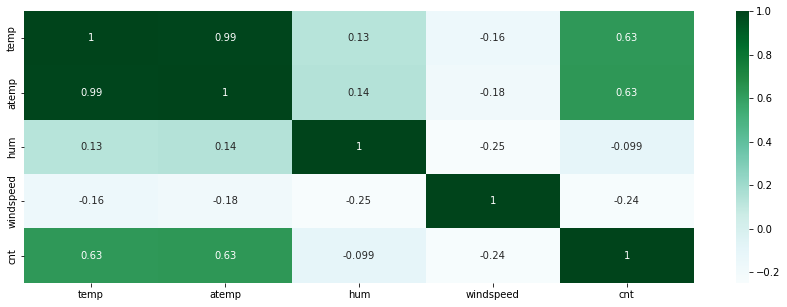

In [59]:
## Heatmap of Correlation among numerical variables 

sns.heatmap(df.corr(), annot=True, cmap='BuGn');

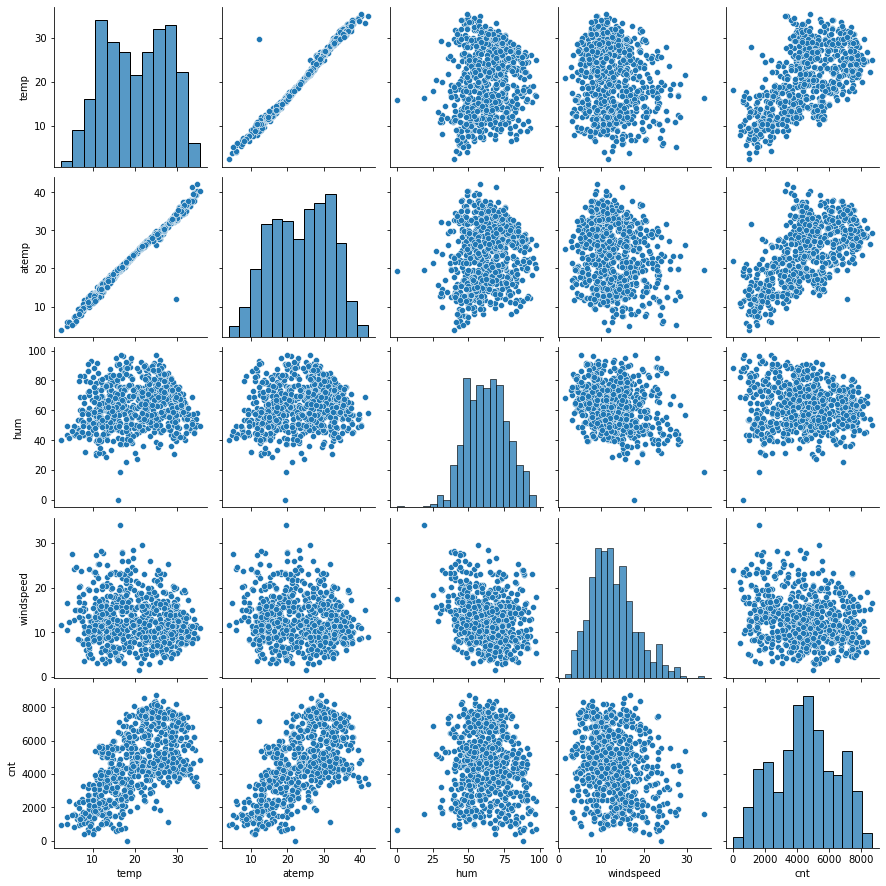

In [60]:
## Pairplot showing the relationship among numerical variables and distributions
sns.pairplot(df);

**Observation**
- Features `temp` and `atemp` have very high correlation(r = 0.99), these two features can cause **Multicollinearity**
- Features `temp` and `atemp` also have resonablly good correlation (r = 0.63) with target variable 'cnt'
- Features `hum`, and `windspeed` does not seems to have good/strong correlation with target variable 

## Data cleaning and preparation


In [61]:
## Descriptive Stats of Numerical Variables
df.describe()

,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,4508.006849
std,7.506729,8.150308,14.237589,5.195841,1936.011647
min,2.424346,3.953480,0.000000,1.500244,22.000000
25%,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,26.880615,30.445775,72.989575,15.625589,5966.000000
max,35.328347,42.044800,97.250000,34.000021,8714.000000


In [62]:
## Descriptive Stats of Categorical Variables
df.describe(include='category')

,season,mnth,holiday,weekday,workingday,weathersit
count,730,730,730,730,730,730
unique,4,12,2,7,2,3
top,3,1,0,0,1,1
freq,188,62,709,105,499,463


**Observation**
- There are 4 independent numerical features and they are in the same range, values between 0 and 100, generally scalling is not required, however will use Minmax scalar to check the effect of scalling
- There are 6 catergorical variables, will use dummy variables technique on them to use in the MLR. 

### Creating Dependent and Independent Variables

In [63]:
## Creating dependent and independent data

X = df.drop(columns='cnt', axis=1)
y = df['cnt']

### Creating Dummy Variables

In [64]:
## Creating Dummy variables and droping the first class representation (k-1)

X = pd.get_dummies(X, drop_first=True)
print(X.shape)
X.head()

(730, 28)


,temp,atemp,hum,windspeed,season_2,season_3,season_4,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
0,14.110847,18.18125,80.5833,10.749882,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,14.902598,17.68695,69.6087,16.652113,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,8.050924,9.47025,43.7273,16.636703,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,8.200000,10.60610,59.0435,10.739832,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,9.305237,11.46350,43.6957,12.522300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


### Creating Train Test Split

In [65]:
## Splitting the data into train and test at 80:20 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(547, 28)
(183, 28)
(547,)
(183,)


### Scaling the data

In [66]:
## extracting numerical columns names

num_cols = X.columns[X.dtypes!='category'].tolist()
num_cols

['temp',
 'atemp',
 'hum',
 'windspeed',
 'season_2',
 'season_3',
 'season_4',
 'mnth_2',
 'mnth_3',
 'mnth_4',
 'mnth_5',
 'mnth_6',
 'mnth_7',
 'mnth_8',
 'mnth_9',
 'mnth_10',
 'mnth_11',
 'mnth_12',
 'holiday_1',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'workingday_1',
 'weathersit_2',
 'weathersit_3']

In [67]:
## Creating scalled data using Minmax Scaler

X_train_sc = X_train.copy()
X_test_sc = X_test.copy()

scaler = MinMaxScaler()
X_train_sc[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_sc[num_cols] = scaler.transform(X_test[num_cols])

X_train_sc.head()

,temp,atemp,hum,windspeed,season_2,season_3,season_4,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
311,0.435124,0.437339,0.743667,0.057471,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
523,0.735215,0.680985,0.482181,0.286093,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
381,0.391151,0.374375,0.737917,0.659615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
413,0.358285,0.362754,0.550880,0.319514,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
253,0.740406,0.695906,0.735509,0.156398,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
X_test_sc.head()

,temp,atemp,hum,windspeed,season_2,season_3,season_4,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
184,0.831783,0.769660,0.657364,0.084219,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
535,0.901354,0.842587,0.610133,0.153728,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
299,0.511964,0.496145,0.837699,0.334206,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
221,0.881625,0.795343,0.437098,0.339570,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
152,0.817246,0.741471,0.314298,0.537414,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Model Development

### Creating first model with all the data

In [69]:
## Adding a constant to the independent data
X_train_sc_sm = sm.add_constant(X_train_sc)


## fitting a linear model
lm = sm.OLS(y_train, X_train_sc_sm).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     29.57
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           2.44e-87
Time:                        19:37:53   Log-Likelihood:                -4666.3
No. Observations:                 547   AIC:                             9389.
Df Residuals:                     519   BIC:                             9509.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2782.9835    409.451      6.797   

In [70]:
## Checking VIF
vif = pd.DataFrame()
X = X_train_sc
vif['features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif.sort_values(by='VIF', ascending=False, inplace=True)
vif

,features,VIF
22,weekday_4,inf
23,weekday_5,inf
20,weekday_2,inf
21,weekday_3,inf
18,holiday_1,inf
19,weekday_1,inf
25,workingday_1,inf
0,temp,455.12
1,atemp,400.27
2,hum,20.75


**Observations**
- We can observe that` weekday 1, 2, 3, 4, 5` and `holiday_1` and `workingday_1` have **VIF = infinity**
    -- VIF is very large or infinity when there is a perfect correlation among independent vaiables

- We also see that the p-value for `weekday 1,2,3,4, 5` is > 0.05 and also for `hoilday_1` p-value is > 0.05

- we also observe that VIF for `temp` and `atemp` is very high and the p-value for `atemp` variables > 0.05
- And there are few other features having VIF > 5, and high p-value, however we address this multicollinearity, by removing one feature at a time

**Feature Selection Approach**
- Will use Recursive Feature Elimination Technique to remove insignificant featrues first and then will manually analysis significance of each feature to be retained for the modeling, based on p-value and VIF value.
- p-value < 0.05 and VIF <= 5 will be used as the critiria for retaining the feature in the modeling

In [71]:
## Deciding the number of features to start with while using REF technique

Adj_r2 = []
for n in np.arange(1, X_train_sc.shape[1]+1):
    lm_rfe = RFE(LinearRegression(), n_features_to_select=n)
    lm_rfe.fit(X_train_sc, y_train)
    rfe_cols = X_train_sc.columns[lm_rfe.support_]
    X_train_rfe = X_train_sc[rfe_cols]
    X_train_rfe_sm = sm.add_constant(X_train_rfe)
    lm = sm.OLS(y_train, X_train_rfe_sm).fit()
    y_train_pred = lm.predict(X_train_rfe_sm)
    r2 = r2_score(y_train, y_train_pred)
    Adj_r2.append(1 - (1-r2) * (X_train_rfe.shape[0]-1)/(X_train_rfe.shape[0]-X_train_rfe.shape[1]-1))

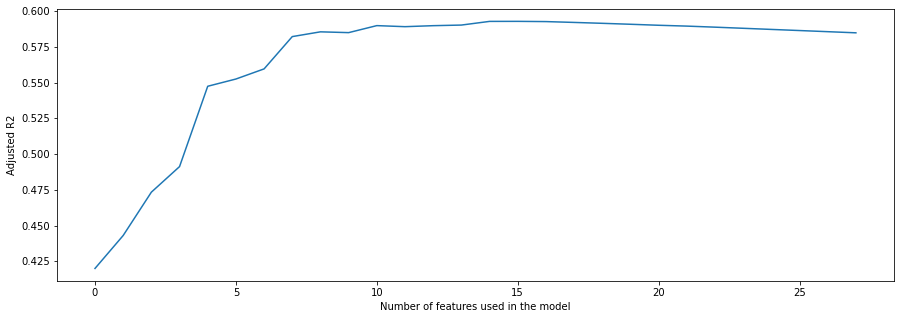

In [72]:
## Plotting the Adjusted R2 for different number of features used in the model
plt.plot(Adj_r2)
plt.xlabel('Number of features used in the model')
plt.ylabel('Adjusted R2');

In [73]:
print('Max Adjususted R2 : %.3f' %np.max(Adj_r2))
print('Number of features that resulted in max Adjusted R2 : ', np.argmax(Adj_r2))

Max Adjususted R2 : 0.593
Number of features that resulted in max Adjusted R2 :  15


**Observations**
- For inclusion of 15 variables the MLR model gives the maximun Adjusted R2 of 0.593
- will use 15 varibales to start with in REF method

### Using RFE method

In [74]:
## Fitting the model with RFE method

lm_rfe = RFE(LinearRegression(), n_features_to_select=15)
lm_rfe.fit(X_train_sc, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [75]:
## listing the feature importance 
list(zip(X_train_sc.columns, lm_rfe.support_, lm_rfe.ranking_))

[('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_2', True, 1),
 ('season_3', False, 4),
 ('season_4', True, 1),
 ('mnth_2', False, 5),
 ('mnth_3', False, 6),
 ('mnth_4', False, 7),
 ('mnth_5', True, 1),
 ('mnth_6', True, 1),
 ('mnth_7', True, 1),
 ('mnth_8', False, 11),
 ('mnth_9', True, 1),
 ('mnth_10', False, 10),
 ('mnth_11', False, 2),
 ('mnth_12', False, 3),
 ('holiday_1', True, 1),
 ('weekday_1', False, 13),
 ('weekday_2', False, 8),
 ('weekday_3', False, 9),
 ('weekday_4', False, 14),
 ('weekday_5', False, 12),
 ('weekday_6', True, 1),
 ('workingday_1', True, 1),
 ('weathersit_2', True, 1),
 ('weathersit_3', True, 1)]

In [76]:
## listing the 15 features that are selected for the modeling 
list(zip(X_train_sc.columns[lm_rfe.support_], lm_rfe.ranking_[[lm_rfe.support_]]))

[('temp', 1),
 ('atemp', 1),
 ('hum', 1),
 ('windspeed', 1),
 ('season_2', 1),
 ('season_4', 1),
 ('mnth_5', 1),
 ('mnth_6', 1),
 ('mnth_7', 1),
 ('mnth_9', 1),
 ('holiday_1', 1),
 ('weekday_6', 1),
 ('workingday_1', 1),
 ('weathersit_2', 1),
 ('weathersit_3', 1)]

**Iteration-0 :: using 15 variables as selected in RFE method**

In [77]:
## using the 15 features selected in RFE method to build the MLR model

rfe_cols = X_train_sc.columns[lm_rfe.support_]

X_train_rfe = X_train_sc[rfe_cols]
X_train_rfe_sm = sm.add_constant(X_train_rfe)

## fitting a linear model
lm = sm.OLS(y_train, X_train_rfe_sm).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     53.99
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           2.02e-96
Time:                        19:37:54   Log-Likelihood:                -4667.8
No. Observations:                 547   AIC:                             9368.
Df Residuals:                     531   BIC:                             9436.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2798.8753    381.404      7.338   

In [78]:
## Checking VIF
vif = pd.DataFrame()
X = X_train_rfe
vif['features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif.sort_values(by='VIF', ascending=False, inplace=True)
vif

,features,VIF
1,atemp,378.90
0,temp,369.36
2,hum,17.21
12,workingday_1,4.85
3,windspeed,4.02
4,season_2,2.54
13,weathersit_2,2.12
11,weekday_6,1.86
6,mnth_5,1.82
5,season_4,1.72


**Observations**
- Using 15 features resulted in an Adjusted R2 of 0.593 and F-statistics is significant
- However, the features `atemp`, `mnth_5`, `mnth_6` and `holiday_1` has high p-values
- Features `atemp`, `temp` and `hum` has high VIF value, since `atemp` has high p-value, this will be droped in the next iteration
- based on the above iteration outcome, decision on dropping further vaiable will be taken

**Iteration-1 :: droping `atemp`**

In [79]:
## Dropping 'atemp'
X_train_rfe_1 = X_train_rfe.drop(columns=['atemp'])

## Adding a constant to the independent data
X_train_sm = sm.add_constant(X_train_rfe_1)

## fitting a linear model
lm = sm.OLS(y_train, X_train_sm).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     57.92
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           2.82e-97
Time:                        19:37:54   Log-Likelihood:                -4667.9
No. Observations:                 547   AIC:                             9366.
Df Residuals:                     532   BIC:                             9430.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2790.3008    380.489      7.333   

In [80]:
## Checking VIF
vif = pd.DataFrame()
X = X_train_rfe_1
vif['features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif.sort_values(by='VIF', ascending=False, inplace=True)
vif

,features,VIF
1,hum,16.66
0,temp,12.16
11,workingday_1,4.85
2,windspeed,3.89
3,season_2,2.48
12,weathersit_2,2.11
10,weekday_6,1.86
5,mnth_5,1.82
4,season_4,1.68
7,mnth_7,1.65


**Observations**
- After dropping `atemp` the VIF of `temp` has come down, but still > 5
- `hum` feature now has the heighest VIF, will be droped in the next iteration 

**Iteration-2 :: droping `hum`**

In [81]:
## Dropping 'hum'
X_train_rfe_2 = X_train_rfe_1.drop(columns=['hum'])

## Adding a constant to the independent data
X_train_sm = sm.add_constant(X_train_rfe_2)

## fitting a linear model
lm = sm.OLS(y_train, X_train_sm).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     57.73
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           8.32e-93
Time:                        19:37:54   Log-Likelihood:                -4680.8
No. Observations:                 547   AIC:                             9390.
Df Residuals:                     533   BIC:                             9450.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1302.3199    247.432      5.263   

In [82]:
## Checking VIF
vif = pd.DataFrame()
X = X_train_rfe_2
vif['features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif.sort_values(by='VIF', ascending=False, inplace=True)
vif

,features,VIF
0,temp,7.47
10,workingday_1,4.28
1,windspeed,3.65
2,season_2,2.48
4,mnth_5,1.82
9,weekday_6,1.74
6,mnth_7,1.61
5,mnth_6,1.60
11,weathersit_2,1.57
3,season_4,1.50


**Observations**
- After dropping `hum` the VIF of `temp` has come down, but still > 5
- This has also resulted in reduction in Adj R2, by 2 points
- `mnth_6` feature now has the heighest p-value, will be droped in the next iteration 

**Iteration-3 :: droping `mnth_6`**

In [83]:
## Dropping 'mnth_6'
X_train_rfe_3 = X_train_rfe_2.drop(columns=['mnth_6'])

## Adding a constant to the independent data
X_train_sm = sm.add_constant(X_train_rfe_3)

## fitting a linear model
lm = sm.OLS(y_train, X_train_sm).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     62.40
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           1.96e-93
Time:                        19:37:54   Log-Likelihood:                -4681.4
No. Observations:                 547   AIC:                             9389.
Df Residuals:                     534   BIC:                             9445.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1331.9645    246.142      5.411   

In [84]:
## Checking VIF
vif = pd.DataFrame()
X = X_train_rfe_3
vif['features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif.sort_values(by='VIF', ascending=False, inplace=True)
vif

,features,VIF
0,temp,6.14
9,workingday_1,4.24
1,windspeed,3.56
2,season_2,2.25
8,weekday_6,1.74
4,mnth_5,1.57
10,weathersit_2,1.56
5,mnth_7,1.50
3,season_4,1.48
6,mnth_9,1.30


**Observations**
- After dropping `mnth_6` the VIF of `temp` has come down, but still > 5
- There is a small reduction in Adj R2
- `holiday_1` feature now has the heighest p-value, will be droped in the next iteration 

**Iteration-4 :: droping `holiday_1`**

In [85]:
## Dropping 'holiday_1'
X_train_rfe_4 = X_train_rfe_3.drop(columns=['holiday_1'])

## Adding a constant to the independent data
X_train_sm = sm.add_constant(X_train_rfe_4)

## fitting a linear model
lm = sm.OLS(y_train, X_train_sm).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     67.72
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           6.88e-94
Time:                        19:37:54   Log-Likelihood:                -4682.6
No. Observations:                 547   AIC:                             9389.
Df Residuals:                     535   BIC:                             9441.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1243.7444    239.128      5.201   

In [86]:
## Checking VIF
vif = pd.DataFrame()
X = X_train_rfe_4
vif['features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif.sort_values(by='VIF', ascending=False, inplace=True)
vif

,features,VIF
0,temp,6.02
8,workingday_1,3.92
1,windspeed,3.42
2,season_2,2.25
7,weekday_6,1.66
4,mnth_5,1.57
9,weathersit_2,1.56
5,mnth_7,1.50
3,season_4,1.47
6,mnth_9,1.29


**Observations**
- After dropping `holiday_1` the VIF of `temp` has come down, but still > 5
- There is a small drop in Adj R2
- `mnth_5` feature now has the heighest p-value, will be droped in the next iteration 

**Iteration-5 :: droping `mnth_5`**

In [87]:
## Dropping 'mnth_5'
X_train_rfe_5 = X_train_rfe_4.drop(columns=['mnth_5'])


## Adding a constant to the independent data

X_train_sm = sm.add_constant(X_train_rfe_5)


## fitting a linear model
lm = sm.OLS(y_train, X_train_sm).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     74.08
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           2.40e-94
Time:                        19:37:54   Log-Likelihood:                -4683.7
No. Observations:                 547   AIC:                             9389.
Df Residuals:                     536   BIC:                             9437.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1252.0446    239.352      5.231   

In [88]:
## Checking VIF
vif = pd.DataFrame()
X = X_train_rfe_5
vif['features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif.sort_values(by='VIF', ascending=False, inplace=True)
vif

,features,VIF
0,temp,5.94
7,workingday_1,3.92
1,windspeed,3.36
2,season_2,1.77
6,weekday_6,1.66
8,weathersit_2,1.55
4,mnth_7,1.50
3,season_4,1.47
5,mnth_9,1.29
9,weathersit_3,1.08


**Observations**
- After dropping `mnth_5` the VIF of `temp` has come down, but still > 5
- There is a small drop in Adj R2
- `mnth_7` feature now has the heighest p-value, will be droped in the next iteration 

**Iteration-6 :: droping `mnth_7`**

In [89]:
## Dropping 'mnth_7'
X_train_rfe_6 = X_train_rfe_5.drop(columns=['mnth_7'])

## Adding a constant to the independent data
X_train_sm = sm.add_constant(X_train_rfe_6)

## fitting a linear model
lm = sm.OLS(y_train, X_train_sm).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     81.66
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           1.16e-94
Time:                        19:37:54   Log-Likelihood:                -4685.3
No. Observations:                 547   AIC:                             9391.
Df Residuals:                     537   BIC:                             9434.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1295.4391    238.510      5.431   

In [90]:
## Checking VIF
vif = pd.DataFrame()
X = X_train_rfe_6
vif['features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif.sort_values(by='VIF', ascending=False, inplace=True)
vif

,features,VIF
0,temp,4.47
6,workingday_1,3.90
1,windspeed,3.33
5,weekday_6,1.66
2,season_2,1.58
7,weathersit_2,1.54
3,season_4,1.40
4,mnth_9,1.21
8,weathersit_3,1.07


**Observations**
- After dropping `mnth_7` the VIF of `temp` has come down below 5.
- There is a small drop in Adj R2
- No features has the p-value > 0.05, and VIF > 5.
- Model has Adjusted R2 of 0.578, though not significantly high for making predictions, but can be considered for understanding the variable relationships with demand.
- Stopping the experimentations, and using this as the final model for interpretation
- Following features are considered in the final model - `temp`, `windspeed`, `season_2`, `season_4`, `mnth_9`, `weekday_6`, `workingday_1`, `weathersit_2`, and `weathersit_3`

## Residual analysis and Model Validation on test data

### Residual Analysis

In [91]:
## Building the MLR model for the selected features and getting prediction for the train data

clf = LinearRegression()
clf.fit(X_train_rfe_6, y_train)
y_train_pred = clf.predict(X_train_rfe_6)

**Testing Normality of residuals**

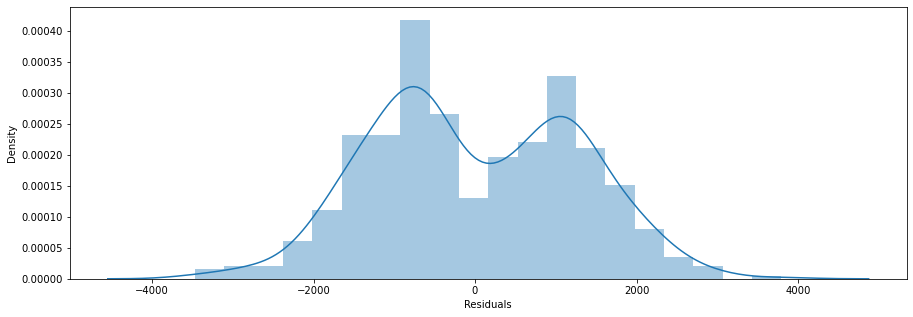

In [92]:
## Distribution of Residuals

res_train = y_train - y_train_pred
sns.distplot(res_train, bins=20)
plt.xlabel('Residuals');

In [93]:
print('Mean of Residuals : %.4f' %res_train.mean())

Mean of Residuals : -0.0000


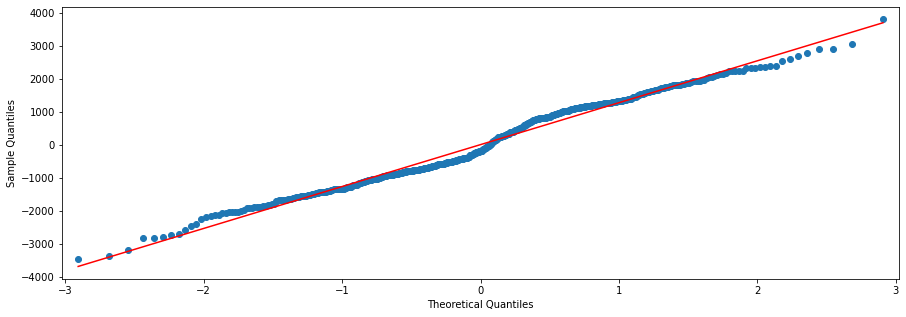

In [94]:
## QQplot to check normality of residuals
qqplot(res_train, line='s');

**Testing Independence of Residuals**

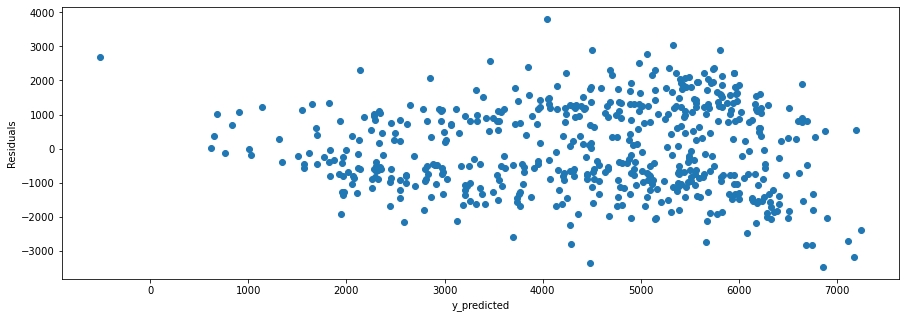

In [95]:
## Scatter plot of residuals vs y_predicted'

plt.scatter(y_train_pred, res_train)
plt.xlabel('y_predicted')
plt.ylabel('Residuals');

**Testing homoscedasticity of residuals**

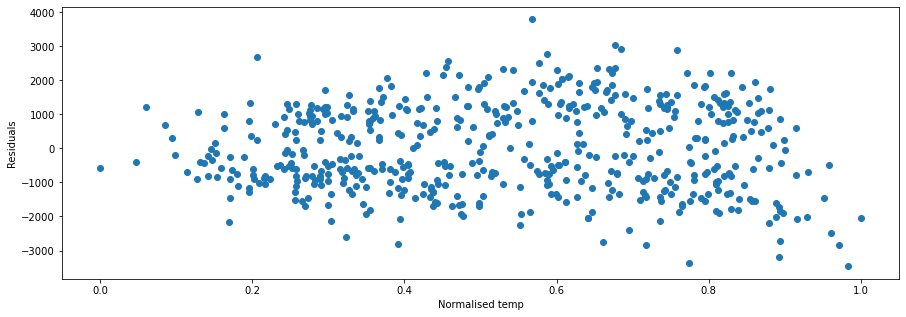

In [96]:
## Scatter plot of residuals vs X variable 'temp'

plt.scatter(X_train_rfe_6['temp'], res_train)
plt.xlabel('Normalised temp')
plt.ylabel('Residuals');

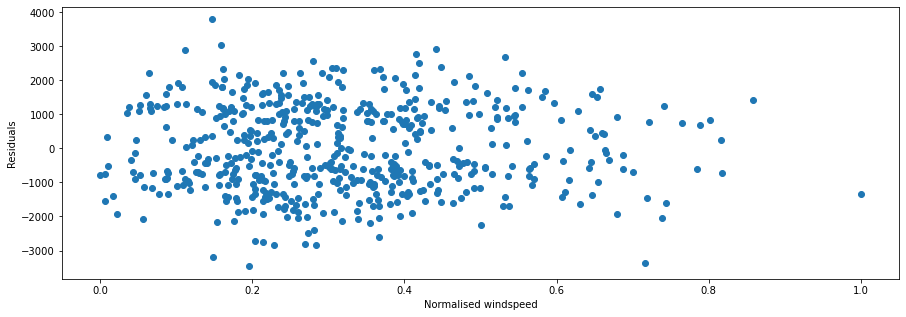

In [97]:
## Scatter plot of residuals vs X variable 'windspeed'
plt.scatter(X_train_rfe_6['windspeed'], res_train)
plt.xlabel('Normalised windspeed')
plt.ylabel('Residuals');

**Observations**

- From QQ plot and distribution polt of  the residuals we conculde that, residulas follow normal distribution but it is bi-modal
- The mean of Residuals is zero
- It can be ovserved that errors are independent
- There is no observable patter in the Residuals Vs dependent variable, hence no precense of Heteroscedasticity 

### Model Validation on Test data

In [98]:
## Extracting the columns used in the last iternation

fin_cols = X_train_rfe_6.columns
fin_cols

Index(['temp', 'windspeed', 'season_2', 'season_4', 'mnth_9', 'weekday_6',
       'workingday_1', 'weathersit_2', 'weathersit_3'],
      dtype='object')

In [99]:
## Subsetting the test data for the columns selected

X_test_rfe_6 = X_test_sc[fin_cols]
X_test_rfe_6.head(1)

,temp,windspeed,season_2,season_4,mnth_9,weekday_6,workingday_1,weathersit_2,weathersit_3
184,0.831783,0.084219,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [100]:
## Predicting on test data
y_test_pred = clf.predict(X_test_rfe_6)

**Comparing adjusted R2 and RMSE for Train and Test data**

In [101]:
## Computing Adjusted R2 for Train data
R2_train = r2_score(y_train, y_train_pred)
Adj_R2_train = 1 - (1-R2_train) * (X_train_rfe_6.shape[0]-1)/(X_train_rfe_6.shape[0]-X_train_rfe_6.shape[1]-1)

## Computing Adjusted R2 for Test data
R2_test = r2_score(y_test, y_test_pred)
Adj_R2_test = 1 - (1-R2_test) * (X_test_rfe_6.shape[0]-1)/(X_test_rfe_6.shape[0]-X_test_rfe_6.shape[1]-1)

print("Train Adjusted R-Squared : %.3f" %Adj_R2_train)
print("Test Adjusted R-Squared : %.3f" %Adj_R2_test)

Train Adjusted R-Squared : 0.571
Test Adjusted R-Squared : 0.421


In [102]:
## Computing Root Mean Squared Errors for Train and Test data
RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Train RMSE : %.2f" %RMSE_train)
print("Test RMSE : %.2f" %RMSE_test)

Train RMSE : 1269.60
Test RMSE : 1387.70


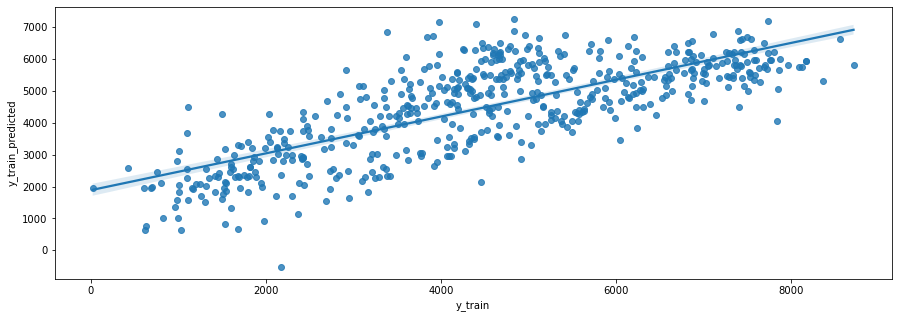

In [103]:
sns.regplot(y_train, y_train_pred)
plt.xlabel('y_train')
plt.ylabel('y_train_predicted');

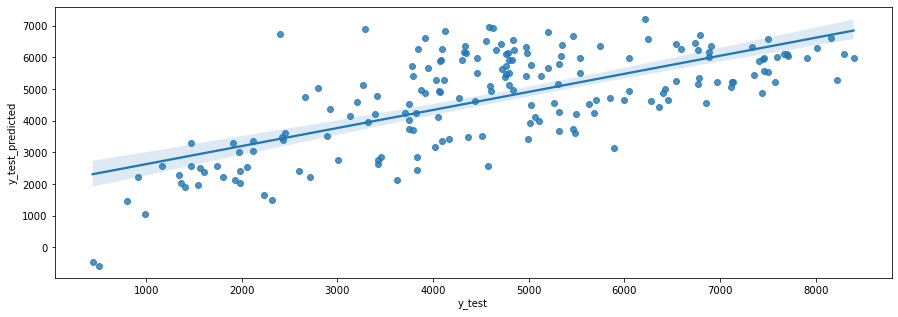

In [104]:
sns.regplot(y_test, y_test_pred)
plt.xlabel('y_test')
plt.ylabel('y_test_predicted');

**Observations**
- Model has high Bias as well as Variance, MLR model underfits the data 
- Model has failed to generalize as test Adjusted R2 is much lower that train Adjusted R2
    - Train Adjusted R2 = 0.571    and Test Adjusted R2 = 0.421
- Model can not completely explain the variance in target variable 
- Current model cannot be used for making prediction

## Conclusion

### Best fit model

$$
count = 1295.4 + (5307.68 * temp) - (1153.59 * windspeed) + (745.78 * season_2) + (1228.76 * season_4) + (792.85 * mnth_9) + (592.63 * weekday_6) + (565.29 * workingday_1) - (685.62 * weathersit_2) - (2876.88 * weathersit_3)  
$$

- Though the model is not good for making predictions accuratly, but can be used for explaining the relationship between various independent variables with demand for the bikes
- **Model Interpretation** 
    - Following features are considered in the final model - `temp`, `windspeed`, `season_2`, `season_4`, `mnth_9`, `weekday_6`, `workingday_1`, `weathersit_2`, and `weathersit_3`
    - `temp` has the postive correlation with demand for the bike, we can see that if there is a unit degree increase in temperature the demans is expected to increase by a mean value of 5307 units, while keeping all other parameters unchanged
    
    - similarly `windspeed` in negetively correlated wtih demand for the bike, if the windspeed increases by 1 unit the demand for the bike is expected to fall by a mean value of 1153
    
    - `season` are positively correlated with demand, if it is `seanson_2(summar)` the demand for the bike is expected to go up 746 units and if the `season_4(winter)` the demand is expected to go up by 1129 units
    
    - If it is `month_9(September)` the demand is expected to increase by 793 units
    
    - If it is a `weekday_6(6th day of the week)` the demand is expected to increase by 593 units
    
    - If it is a `Workingday` the demand is expected to increase by 565 units
    
    - Type of weather has a negivite impact on the demand for the bike if the weather type is either `2(Mist, Cloudy..)` or `3 (Light snow, Light Rian...)`, deamand is expected to go down by 686 units and 2877 units respectively 
    
    
- **Suggetions**

    - We can considering certain promotional offers during Windydays, non-working days, holidays or when the weather type is 2(Mist, Cloudy..) or 3 (Light snow, Light Rian...)
    - We can also consider some loyalty offering to boost the rentals during working days, summar and winter seasons 
    